# Regression Analysis of Short Term Rentals

## Table of Contents
<ul>
<li><a href="#research">Research Question</a></li>
<li><a href="#collection">Data Collection</a></li>
<li><a href="#extraction">Data Extraction and Preparation</a></li>
<li><a href="#analysis">Analysis</a></li>
    <ul><li><a href="#eda">Exploratory Data Analysis</a></li>
        <li><a href="#ols">Ordinary Least Squares Regression</a></li>
        <li><a href="#lasso">Lasso Regression</a></li>
        <li><a href="#ridge">Ridge Regression</a></li>
        <li><a href="#rf">Random Forest Regression</a></li>
        <li><a href="#xgboost">XGBoost Regression</a></li></ul>
   <li><a href="#summary">Data Summary and Implications</a>
     <li><a href="#sources">Sources</a> 
</ul>


<a id='research'></a>
## Research Question

Do penalized linear and decision tree based regression methods perform better than Ordinary Least Squares regression?

[Airbnb](https://www.airbnb.com/) is a platform that allows hosts to rent out properties to patrons looking to visit locations all over the world.   This study will explore data on Airbnb rentals in New York city to predict the price of a rental.  It will also utilize census data and other geospatial datasources for prediction.  Our null and alternative hypotheses are listed below.


$H_0$: **There is not a large difference(less than 10%) in machine learning performance between penalized linear and decision tree based regression methods and ordinary least squares regression.**

$H_1$: **There is a large difference(greater than 10%)  in machine learning performance between penalized linear and decision tree based regression methods and ordinary least squares regression.**


The mean squared error of four different regression techniques (2 penalized and 2 decision tree based) will be compared with the mean squared error of OLS regression.  If at least one of the four regression techniques has at least 10% less mean squared error than OLS regression the null hypothesis will be rejected.  There is merit to studying this topic in the context of Airbnb rentals because Airbnb rentals can have an effect on housing costs<sup>1</sup> and studies in the past have shown that alternative regression techniques can perform better than OLS regression<sup>2</sup>.



<a id='collection'></a>
## Data Collection

Data from three sources will be used for this study.  The datasets will be merged into one final dataset for analysis.  All three datasets are available for public use.  The first dataset being used is available for download on the kaggle website.  Kaggle is an online data science community that hosts data science and machine learning competitions.  The New York City Airbnb data is located [here](
 https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data/).  The second data source is Census data from the American Factfinder [website](https://factfinder.census.gov/faces/nav/jsf/pages/download_center.xhtml#none).  American Factfinder stores historical census data.  The data this study will use is from the American Community Survey.  Five tables from the 2017 ACS 5 Year estimates will be used.  The tables are ACS_17_5YR_S0101, ACS_17_5YR_S1501, ACS_17_5YR_S1701, ACS_17_5YR_S1903,  and ACS_17_5YR_S2301.  The initial approach was to extract data from the American Factfinder website via an API, however this required a API key to be generated.  Due to time contstraints, this hurdle was overcome by exploring the American Factfinder website and finding the download interface.  The interface was used to access the American Communicy Survey tables that were used for the study.  The data was pulled for all Census Tracts in the state of New York.
 
The series of screenshots below describe how to download these datasets.
 
<img src="info/data step 1.jpg">
<img src="info/data_part_first.jpg">
<img src="info/data_part_two.jpg">
<img src="info/factfinder.jpg">

The third source of data is the [Google Big Query](https://cloud.google.com/bigquery/public-data/) public data repository.  Public datasets from the New York tree census, subway entrance locations and census tracts were extracted.  The full tables that were extracted form the Google Big Query interface are *bigquery-public-data.new_york_subway.station_entrances*, *bigquery-publicdata.geo_census_tracts.census_tracts_new_york* and *bigquery-publicdata.new_york.tree_census_2015*.  The tables are extracted using *select * from [TABLE]* queries from the Google Big Query web UI. For easy access, all datasets from each of these sources are saved in at this [link](https://drive.google.com/file/d/1g29pGGJ0kj7Bxq0WEypAWQ2PwwKd6vAX/view).

All of the datasets used for this analysis were extracted manually from a few different public websites.  The advantages of using this methodology is that it does not require a significant technical effort to acquire the data. The data could also be acquired in a similar fashion by following the data collection steps above.  It also does not require any API keys or API calls to be made.  A disadvantage of this methodology is that it requires a human to manually go out to these websites and extract the data.  It also requires some research to look into where to acquire data that would be useful to our analysis. A more sophisticated method would be to extract data via an API or via a webscraping technique using python.  This would remove a lot of the manual steps of going out to each website and downloading the data.  It would also allow all the work to be done automatically via python code.


 

<a id='extraction'></a>
## Data Extraction and Preparation

Data was extracted and prepared using the python programming language.  The first step of the process is to load the libraries needed for our data preparation.  Pandas is loaded for data preparation and file processing.  Geopandas, the Shapely Point and Polygon classes and the shapely function wkt are loaded for the handling of geospatial location data.  Numpy is loaded for matrix and mathematical processing.  Finally the seaborn and matplotlib libraries are loaded for data visualization.

The next step in our process is to load the initial Airbnb New York city data set into a pandas dataframe.  Once loaded we convert the pandas dataframe into a geopandas dataframe, using the latitude and longitude as the geometry for the dataframe.  The same loading and conversion process is done with the New York Census tract dataset, however we are using creating a Polygon as the geometry of the geopandas dataframe instead of a Point.

*Note: code detailing the above steps is below*

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely import wkt
df1 = pd.read_csv('datasets/AB_NYC_2019.csv',index_col=False)



In [2]:
##create geometry for lat long
gdf = gpd.GeoDataFrame(df1,geometry = [Point(x,y) for x,y in zip(df1.longitude,df1.latitude)])

In [3]:
census_tracts = pd.read_csv('datasets/newyorkcensustracts.csv')

In [4]:
##convert to geopandas dataframe so we can get censustract
census_tracts['tract_geom'] = census_tracts['tract_geom'].apply(wkt.loads)
gdf_census = gpd.GeoDataFrame(census_tracts,geometry='tract_geom')

In [5]:
##set index as geo_id so we can create dictionary
gdf_census.set_index('geo_id',inplace=True)

In [6]:
geo_id_map = gdf_census['tract_geom'].to_dict()

The Point class in the context of the geopandas and shapely libraries is a constructor that takes a positional coordinate value or tuple paramater and creates a specific Point in a two dimensional space<sup>3</sup>.  The Polygon class takes an ordered sequence of paramaters and creates a two dimensional object connecting those points.  The Point and Polygon classes can be used with latitudes and longitudes to perform various calculations.  In the context of this analysis, the *within* method is used on a specific point to check if it is within a Polygon.  This is done to acquire the specific census tract for each observation in our Airbnb dataset.  The code that does this check is in the *check_geo_id* function below.  This code takes a few minutes to run but once done we have a census tract for each observation from the Airbnb data.  In total there are 1924 unique census tracts in our data.  The data is saved out to a new enhanced dataset so the code does not need to be run again.



In [7]:
##quick apply_func to set up census_tract
def check_geo_id(x):
    for key in geo_id_map.keys():
        polygon = geo_id_map[key]
        if x.within(polygon):
            return key
        
gdf['census_tract'] = gdf['geometry'].apply(check_geo_id)

In [8]:
df = pd.read_csv('./enhanced_datasets/AB_NYC_2019_w_census_tract.csv',index_col=0)
df['geometry']=df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df,geometry = 'geometry')

In [9]:
gdf['census_tract'].nunique()

1924

In [10]:
##save out as first enhanced dataset
gdf.to_csv('enhanced_datasets/AB_NYC_2019_w_census_tract.csv')

The next step in the data merging process is to merge together all five our census datasets.  Each table is saved in a .csv file so we read our data into a dataframe and look at each set of data so we can manually choose what data we want to append.  The S0101 data contains age distributions for each census tract.  Eighteen columns are chosen from the dataset for age distributions from Under 5 years old to over 85 years old.  Certain age distributions may have a correlation with the price of a rental so they may be useful features for prediction.  At least one feature from each of our remaining census data sets.  Median earnings metrics are pulled from the S1903 and S1502 datasets.  Unemployment rate is pulled from the S2301 dataset and Percent below poverty level is pulled from the S1701 datasets.  These features could also be correlated with Airbnb prices, so they may be useful to the models we build.  

In [11]:
##Step 2 get other enhanced data

df1 = pd.read_csv('./datasets/ACS_17_5YR_S0101_with_ann.csv',header=1)
first_set = df1[['Id2']+[col for col in df1.columns if 'Error' not in col and 'Male' not in col and 'Female' not in col and 'Percent' in col and 'AGE' in col]]
age_dists = first_set[list(first_set.columns[0:19])]

In [12]:
df2 = pd.read_csv('./datasets/ACS_17_5YR_S1501_with_ann.csv',header=1)
median_earnings = df2[['Id2','Total; Estimate; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings']]

In [13]:
merge_list = [age_dists, median_earnings]

In [14]:
df3 = pd.read_csv('./datasets/ACS_17_5YR_S2301_with_ann.csv',header=1)
unemployment_rate = df3[['Id2','Unemployment rate; Estimate; Population 16 years and over']]
merge_list.append(unemployment_rate)

In [15]:
df4 = pd.read_csv('./datasets/ACS_17_5YR_S1903_with_ann.csv',header=1)
median_income_households = df4[['Id2','Median income (dollars); Estimate; Households']]
merge_list.append(median_income_households)

In [16]:
df5 = pd.read_csv("./datasets/ACS_17_5YR_S1701_with_ann.csv",header=1)
poverty = df5[['Id2','Percent below poverty level; Estimate; Population for whom poverty status is determined']]
merge_list.append(poverty)

In [17]:

census_data_list = []
for item in merge_list:
    new_item = item.set_index('Id2')
    census_data_list.append(new_item)
    
final_census_data = pd.concat(census_data_list,axis=1)
    

In [18]:
final_census_data.to_csv('./enhanced_datasets/census_data_to_append.csv')

The next two datasets that are going to be merged are the subway entrance and new york trees datasets.  The number of subway entrances, alive trees, tree stumps and dead trees will be aggregated per census tract and used to merge with our Airbnb data.  This is done in a similar fashion as merging the census tract with our Airbnb data.  The *within* method will be used for each census tract polygon and then that will be summed up and added to a dictionary that contains the census tracts and sum.  The dictionaries will be usedto create a dataframe with the counts for each census tract.  In total, there are 1866 subway entrances to count up and nearly 700,000 trees.  The process that creates the dictionaries can take an hour or two.

In [19]:
subways = pd.read_csv('./datasets/newyorksubwayent.csv')

In [20]:
subways.shape[0]

1866

In [21]:
for col in subways.columns:
    if col.endswith('geom'):
        subways[col] = subways[col].apply(wkt.loads)

In [22]:
subways_gdf = gpd.GeoDataFrame(subways, geometry = 'entrance_geom')

In [23]:
subway_entrance_dict = {}

for key in geo_id_map.keys():
    if key in gdf['census_tract'].unique():
        polygon = geo_id_map[key]
        entrance_cnt = subways_gdf['entrance_geom'].apply(lambda x: x.within(polygon)).sum()
        subway_entrance_dict[key] = entrance_cnt
        


In [24]:
num_sub_stations = pd.Series(subway_entrance_dict)
new_sub_stations = pd.DataFrame(num_sub_stations, columns=['entrance_cnt'])

In [25]:
new_sub_stations.to_csv('./enhanced_datasets/subway_entrances.csv')

In [26]:
trees = pd.read_csv('./datasets/newyorktrees.csv')

In [27]:
trees['status'].value_counts()

Alive    652173
Stump     17654
Dead      13961
Name: status, dtype: int64

In [28]:
trees_geo = gpd.GeoDataFrame(trees,geometry = [Point(x,y) for x,y in zip(trees.longitude,trees.latitude)])

In [29]:
tree_list = []
i=0
for key in geo_id_map.keys():
    if key in gdf['census_tract'].unique():
        polygon = geo_id_map[key]
        alive_tree_cnt = trees_geo[trees_geo['status']=='Alive']['geometry'].apply(lambda x: x.within(polygon)).sum()
        dead_tree_cnt = trees_geo[trees_geo['status']=='Dead']['geometry'].apply(lambda x: x.within(polygon)).sum()
        stump_tree_cnt = trees_geo[trees_geo['status']=='Stump']['geometry'].apply(lambda x: x.within(polygon)).sum()
        total_tree_cnt = alive_tree_cnt+dead_tree_cnt+stump_tree_cnt
        tree_list.append((key,alive_tree_cnt,dead_tree_cnt,stump_tree_cnt,total_tree_cnt))
        i+=1
        if i%500==0:
            print('500 are completed')


500 are completed
500 are completed
500 are completed


In [30]:
tree_df = pd.DataFrame(tree_list, columns = ['census_tract','alive_tree_cnt','dead_tree_cnt','stump_tree_cnt','total_tree_cnt'])
tree_df.to_csv('./enhanced_datasets/nyc_trees_data.csv',index=False)

All the acquired data is now ready to be merged into one final dataframe for modelling and analysis.  The python os library is used to loop through all the files in the enhanced_datasets folder and merge them together into one dataset.  This dataset is then merged with our Airbnb dataset by census tract to create a final dataset for modelling and analysis. 

In [31]:
import os
files_to_merge = [file for file in os.listdir('./enhanced_datasets') if file.endswith('.csv') and not file.startswith("AB")]
files_to_merge

['census_data_to_append.csv', 'nyc_trees_data.csv', 'subway_entrances.csv']

In [32]:
dfs= []
for file in files_to_merge:
    df = pd.read_csv(os.path.join('./enhanced_datasets',file),index_col=0)
    dfs.append(df)
    
final_df = pd.concat(dfs,axis=1,sort=True)


In [33]:
df_to_merge = final_df[final_df['alive_tree_cnt'].notna()].reset_index()

In [34]:
air_bnb = pd.read_csv(os.path.join('./enhanced_datasets','AB_NYC_2019_w_census_tract.csv'),index_col=0)


In [35]:
final_air_bnb = air_bnb.merge(df_to_merge,how='left',left_on = 'census_tract',right_on = 'index')


In [36]:
final_air_bnb.to_csv('./enhanced_datasets/AB_NYC_2019_merged_data.csv')

In [37]:
final_air_bnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48895 entries, 0 to 48894
Data columns (total 46 columns):
id                                                                                                                                          48895 non-null int64
name                                                                                                                                        48879 non-null object
host_id                                                                                                                                     48895 non-null int64
host_name                                                                                                                                   48874 non-null object
neighbourhood_group                                                                                                                         48895 non-null object
neighbourhood                                                                      

Python was used for the data preparation process.  Python is a free, open source programming language that has a large development community.  It has many useful packages for statistics, machine learning, geospatial analysis and data visualization. Python doesn’t require an expensive server, network or storage hardware that might be needed for a language like SPSS or SAS.  Jupyter notebooks were used for the data preparation process.  With a jupyter notebook, one can write code and explain it in the same interface.  This makes it fairly straightforward to explain each of the steps that are taken in the data preparation process.  Jupyter notebooks can also be saved in a variety of formats which makes them easy to share.  For the data preparation process, we used the Shapely and geopandas libraries.  The advantage of these libraries is we can easily do geospatial calculations with only a few lines of code.

<a id='analysis'></a>
## Analysis

Analysis will be performed in 6 steps.  First, exploratory data analysis will be performed to assess features, missing values and distributions.  Second, a base model will be created using OLS (ordinary least squares) regression.  The model will be assessed using 5-fold cross validation the average mean squared error accross each fold will be used as the performance base line.  Steps 3-6 through, will be the model creation and assessment of the four regression techniques.  The techniques are: Lasso, Ridge, Random Forest and XGBoost regression.  Each model created will also be run through 5-fold cross validation and the average mean squared error will be used to compare with our base line performance.

<a id='eda'></a>
## Exploratory Data Analysis

Exploratory data analysis will be performed on the dataset generated in our data extraction and preparation steps.  Exploratory data analysis (EDA) is a a type of data analysis the lends importance to keeping an open mind<sup>4</sup>. The goals of this analysis is to understand the various distributions of our dataset, assess missing values and determine the features that will be most useful for our modelling.  Various plots and charts will be created and feature engineering may also be performed if analysis shows it can be useful.  The EDA code is below.

In [38]:
##First we've seen our info and we know there are quite a few fields that python has read as object
##lets review those

final_air_bnb[[col for col in final_air_bnb.columns if final_air_bnb[col].dtype==object]].head()

,name,host_name,neighbourhood_group,neighbourhood,room_type,last_review,geometry,Percent; Estimate; AGE - Under 5 years,Percent; Estimate; AGE - 5 to 9 years,Percent; Estimate; AGE - 10 to 14 years,...,Percent; Estimate; AGE - 60 to 64 years,Percent; Estimate; AGE - 65 to 69 years,Percent; Estimate; AGE - 70 to 74 years,Percent; Estimate; AGE - 75 to 79 years,Percent; Estimate; AGE - 80 to 84 years,Percent; Estimate; AGE - 85 years and over,Total; Estimate; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings,Unemployment rate; Estimate; Population 16 years and over,Median income (dollars); Estimate; Households,Percent below poverty level; Estimate; Population for whom poverty status is determined
0,Clean & quiet apt home by the park,John,Brooklyn,Kensington,Private room,2018-10-19,POINT (-73.97237 40.64749),10.7,4.8,4.6,...,7.5,2.9,3.6,0.9,1.0,0.7,59821,5.0,81944,15.8
1,Skylit Midtown Castle,Jennifer,Manhattan,Midtown,Entire home/apt,2019-05-21,POINT (-73.98376999999999 40.75362),2.2,1.1,2.5,...,0.6,0.7,0.4,0.0,1.2,0.6,99875,6.5,133142,14.6
2,THE VILLAGE OF HARLEM....NEW YORK !,Elisabeth,Manhattan,Harlem,Private room,NaN,POINT (-73.9419 40.80902),5.3,7.3,4.3,...,4.3,2.2,2.8,1.2,0.4,1.1,49173,8.4,70651,20.6
3,Cozy Entire Floor of Brownstone,LisaRoxanne,Brooklyn,Clinton Hill,Entire home/apt,2019-07-05,POINT (-73.95976 40.68514),3.5,2.5,3.5,...,4.0,3.1,3.6,1.3,2.5,2.7,49821,8.6,71188,8.4
4,Entire Apt: Spacious Studio/Loft by central park,Laura,Manhattan,East Harlem,Entire home/apt,2018-11-19,POINT (-73.94399 40.79851),5.1,3.8,6.9,...,5.4,3.2,2.9,2.0,2.1,4.2,33504,10.0,27132,34.1


A few items will need to be addressed with the object columns in order to prepare our dataset for modelling.  One, the last review column is a date column with some null values.  A date column would be hard to use for our model but we can use the column to create a feature which will be called days since last review.  In order to generate this new feature, the last review column will need to be converted to a date.  We will use the max review date as the starting point and if there is no review (last review is null) we will make the new feature -1.

In [39]:
import datetime as dt
final_air_bnb['last_review'] = pd.to_datetime(final_air_bnb['last_review'])

In [40]:
final_air_bnb['days_since_last_review'] = ((final_air_bnb['last_review'].max() - final_air_bnb['last_review']).dt.days).fillna(-1).astype(int)

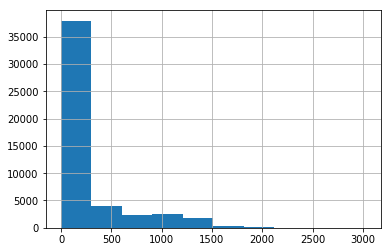

In [41]:
final_air_bnb['days_since_last_review'].hist()

Second, the percent based columns have been read in as objects when we expect them to be numeric values.  This data will be reviewed to determine how to do the numerical conversion.

In [42]:
col_length = len([col for col in final_air_bnb.columns if final_air_bnb[col].dtype==object][6:])


def check_float(x):
    try:
        float(x)
        return True
    except ValueError:
        return False

final_air_bnb['NO_NUM'] = final_air_bnb[[col for col in final_air_bnb.columns if final_air_bnb[col].dtype==object][6:]].applymap(check_float).sum(axis=1)<col_length
final_air_bnb[final_air_bnb['NO_NUM']][[col for col in final_air_bnb.columns if final_air_bnb[col].dtype==object][6:]].shape[0]
final_air_bnb_save = final_air_bnb.copy()


There are 283 records that have objects for what should be float columns.  These are objects in two different ways.  The first way is that there is a "-" filled in for the value.  A assumption we can make with this value is that the data is not avaialable and they can be filled with a null value.  The second way is that there are figures that say "250,000+".  For these cases, the "+" will be removed so we have a normal number.  Since 283 records represent a small portion of our overall data set (less than .5%) records with null values for these figures can most likely be dropped for when we do our analysis.

In [43]:
final_air_bnb = final_air_bnb_save

In [44]:

final_air_bnb.loc[final_air_bnb['NO_NUM'],[col for col in final_air_bnb.columns if final_air_bnb[col].dtype==object][6:]] = final_air_bnb\
.loc[final_air_bnb['NO_NUM'],[col for col in final_air_bnb.columns if final_air_bnb[col].dtype==object][6:]].applymap(lambda x: np.nan if x=='-' else x.replace('+','').replace(',','') if '+' in x else x)


In [45]:
for col in [col for col in final_air_bnb.columns if final_air_bnb[col].dtype==object][6:]:
    final_air_bnb[col] = final_air_bnb[col].astype(np.float)

In [46]:
final_air_bnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48895 entries, 0 to 48894
Data columns (total 48 columns):
id                                                                                                                                          48895 non-null int64
name                                                                                                                                        48879 non-null object
host_id                                                                                                                                     48895 non-null int64
host_name                                                                                                                                   48874 non-null object
neighbourhood_group                                                                                                                         48895 non-null object
neighbourhood                                                                      

There are two columns with quite a few null values in them, last_review and reviews_per_month.  The reason there may be null values is because there are 0 reviews for these properties.  These will be compared with number_of_reviews to see if the theory is true.

In [47]:
(final_air_bnb['reviews_per_month'].isna()).sum(),(final_air_bnb['last_review'].isna()).sum(), (final_air_bnb['number_of_reviews']==0).sum()

(10052, 10052, 10052)

In [48]:
((final_air_bnb['reviews_per_month'].isna()) & (final_air_bnb['last_review'].isna()) & (final_air_bnb['number_of_reviews']==0)).sum()

10052

The theory is correct.  The reviews_per_month field can safely be filled with a 0 value.  The last_review field does not need to be filled as we have already used it to create our feature for days_since_last_review.

In [49]:
final_air_bnb['reviews_per_month'] = final_air_bnb['reviews_per_month'].fillna(0)

In [50]:
final_air_bnb['price'].describe()


count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

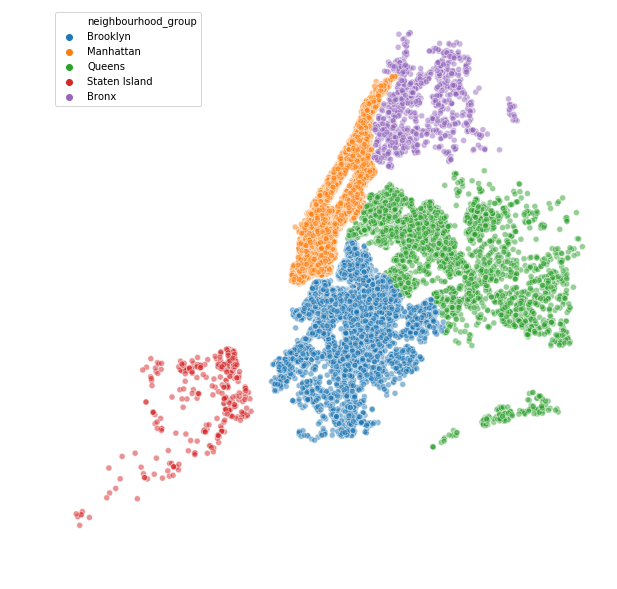

In [51]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.scatterplot(x=final_air_bnb['longitude'],y=final_air_bnb['latitude'],hue=final_air_bnb['neighbourhood_group'],ax=ax,alpha=0.5)
plt.axis('off');

In [52]:
final_air_bnb['price_percentile']=final_air_bnb['price'].rank()/final_air_bnb.shape[0]

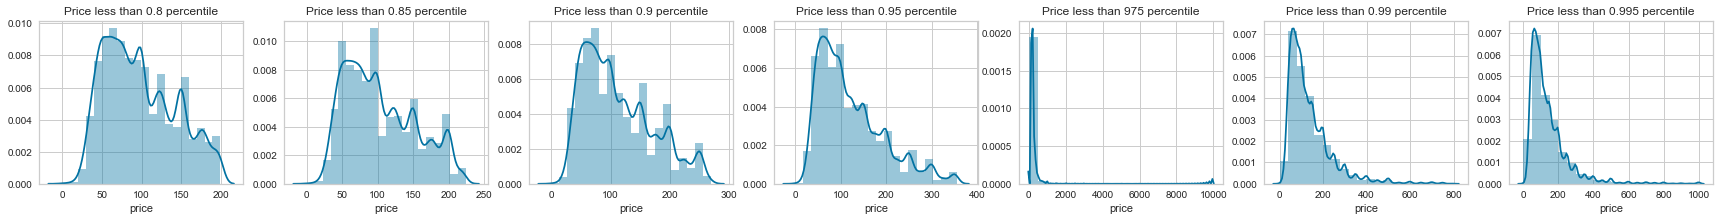

In [175]:
test_percentiles = [.8,.85,.9,.95,975,.99,.995]

fig, axes = plt.subplots(1,len(test_percentiles),figsize=(30,3))
i=0
for percentile in test_percentiles:    
    sns.distplot(final_air_bnb[final_air_bnb['price_percentile']<=percentile]['price'],bins=20, ax=axes[i])
    axes[i].set_title("Price less than {} percentile".format(str(percentile)))
    i+=1
    

The target variable, price is right skewed even when eliminating higher outliers.  As higher percentile prices are eliminated the distribution starts to look more normal.

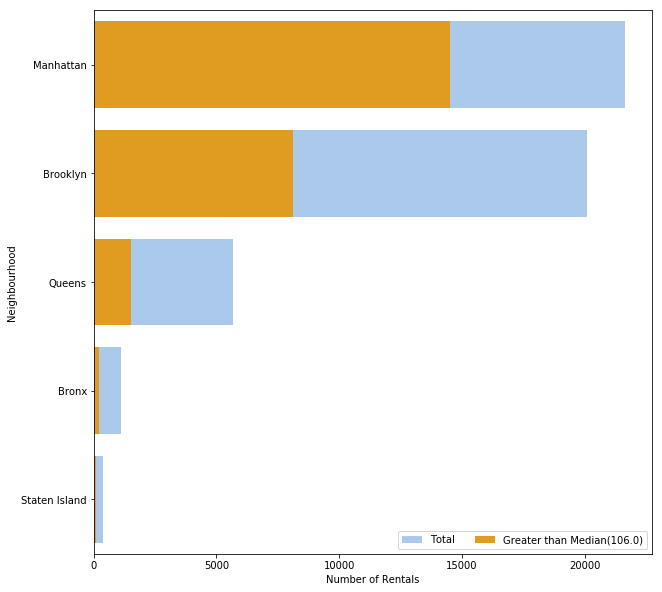

In [54]:
final_air_bnb['higher_than_median'] = (final_air_bnb['price_percentile']>0.5)
fig2, ax2 = plt.subplots(figsize=(10,10))

sns.set_color_codes("pastel")
count_data = pd.concat([final_air_bnb['neighbourhood_group'].value_counts(),final_air_bnb[final_air_bnb['higher_than_median']]['neighbourhood_group'].value_counts()],axis=1)
count_data.columns=['total','greater_than_median']
count_data['neighbourhood_group'] = count_data.index
sns.barplot(x='total',y='neighbourhood_group',data=count_data,
           label='Total',color='b',ax=ax2)

sns.set_color_codes('muted')
sns.barplot(x='greater_than_median',y='neighbourhood_group',data=count_data,
           label='Greater than Median({})'.format(str(final_air_bnb['price'].median())),color='orange',ax=ax2)
ax2.legend(ncol=2, loc='lower right',frameon=True)
ax2.set_ylabel("Neighbourhood")
ax2.set_xlabel('Number of Rentals');

In [55]:
final_air_bnb.groupby('neighbourhood_group')['price'].mean().sort_values(ascending=False)

neighbourhood_group
Manhattan        196.875814
Brooklyn         124.383207
Staten Island    114.812332
Queens            99.517649
Bronx             87.496792
Name: price, dtype: float64

From the above plot, one can see that Manhatten and Brooklyn make the majority of our dataset.  Manhatten has the highest proportion of rentals with a price greater than our median.  The average price of a rental in Manhatten is more than 70 dollars more than the average price in the next highest (Brooklyn).

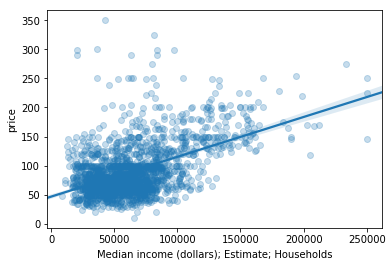

In [56]:
# sns.regplot(x='price',y='Median income (dollars); Estimate; Households',data=final_air_bnb[final_air_bnb['price_percentile']<=.95])
test_med = final_air_bnb[final_air_bnb['price_percentile']<=.95].groupby('census_tract')[['price','Median income (dollars); Estimate; Households']].median()

sns.regplot(x='Median income (dollars); Estimate; Households',y='price',data=test_med,scatter_kws={'alpha':.25})

In [57]:

name_change_dict = {'Percent; Estimate; AGE - Under 5 years': 'percent_Under_5_years',
 'Percent; Estimate; AGE - 5 to 9 years': 'percent_5_to_9_years',
 'Percent; Estimate; AGE - 10 to 14 years': 'percent_10_to_14_years',
 'Percent; Estimate; AGE - 15 to 19 years': 'percent_15_to_19_years',
 'Percent; Estimate; AGE - 20 to 24 years': 'percent_20_to_24_years',
 'Percent; Estimate; AGE - 25 to 29 years': 'percent_25_to_29_years',
 'Percent; Estimate; AGE - 30 to 34 years': 'percent_30_to_34_years',
 'Percent; Estimate; AGE - 35 to 39 years': 'percent_35_to_39_years',
 'Percent; Estimate; AGE - 40 to 44 years': 'percent_40_to_44_years',
 'Percent; Estimate; AGE - 45 to 49 years': 'percent_45_to_49_years',
 'Percent; Estimate; AGE - 50 to 54 years': 'percent_50_to_54_years',
 'Percent; Estimate; AGE - 55 to 59 years': 'percent_55_to_59_years',
 'Percent; Estimate; AGE - 60 to 64 years': 'percent_60_to_64_years',
 'Percent; Estimate; AGE - 65 to 69 years': 'percent_65_to_69_years',
 'Percent; Estimate; AGE - 70 to 74 years': 'percent_70_to_74_years',
 'Percent; Estimate; AGE - 75 to 79 years': 'percent_75_to_79_years',
 'Percent; Estimate; AGE - 80 to 84 years': 'percent_80_to_84_years',
 'Percent; Estimate; AGE - 85 years and over': 'percent_85_years_and_over',
 'Total; Estimate; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings': 'median_earnings_past_12',
 'Unemployment rate; Estimate; Population 16 years and over': 'unemployment_rate',
 'Median income (dollars); Estimate; Households': 'median_income_household',
 'Percent below poverty level; Estimate; Population for whom poverty status is determined': 'poverty_rate'}

final_air_bnb.rename(columns=name_change_dict,inplace=True)

In [58]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

corr = final_air_bnb.corr()

corr.style.background_gradient(cmap='coolwarm',axis=None)

In [59]:
corr = final_air_bnb.corr()
corr[['price']].sort_values(by='price',ascending = False).style.background_gradient(cmap='coolwarm',axis=None)

,price
price,1
price_percentile,0.466096
higher_than_median,0.350089
median_earnings_past_12,0.234176
median_income_household,0.206324
entrance_cnt,0.0897627
percent_30_to_34_years,0.0875464
availability_365,0.0818288
percent_35_to_39_years,0.0662135
calculated_host_listings_count,0.0574717


In [60]:
corr[['price']].abs().sort_values(by='price',ascending = False).style.background_gradient(cmap='coolwarm',axis=None)

,price
price,1
price_percentile,0.466096
higher_than_median,0.350089
median_earnings_past_12,0.234176
median_income_household,0.206324
longitude,0.150019
poverty_rate,0.130837
percent_10_to_14_years,0.126925
unemployment_rate,0.119108
percent_5_to_9_years,0.111408


Correlation analysis above indicates that the feature with the highest correlation to price is median earnings in the past 12 months.

In [61]:
census_plot_data = pd.concat([final_air_bnb[final_air_bnb['price_percentile']<=.975].groupby('census_tract')[['price','median_earnings_past_12','poverty_rate']].median(),final_air_bnb['census_tract'].value_counts()],axis=1,sort=True).rename(columns={'census_tract':'count'})
plot_data = pd.concat([gdf_census.loc[census_plot_data.index],census_plot_data],axis=1,sort=True)
plot_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1924 entries, 36005000200 to 36119001502
Data columns (total 16 columns):
state_fips_code            1924 non-null int64
county_fips_code           1924 non-null int64
tract_ce                   1924 non-null int64
tract_name                 1924 non-null float64
lsad_name                  1924 non-null object
functional_status          1924 non-null object
area_land_meters           1924 non-null int64
area_water_meters          1924 non-null int64
internal_point_lat         1924 non-null float64
internal_point_lon         1924 non-null float64
internal_point_geo         1924 non-null object
tract_geom                 1924 non-null object
price                      1922 non-null float64
median_earnings_past_12    1894 non-null float64
poverty_rate               1902 non-null float64
count                      1924 non-null int64
dtypes: float64(6), int64(6), object(4)
memory usage: 255.5+ KB


In [62]:
plot_data[['price','median_earnings_past_12','poverty_rate','count']].head()

,price,median_earnings_past_12,poverty_rate,count
36005000200,75.0,35108.0,22.9,1
36005000400,90.0,51699.0,11.1,15
36005001600,100.0,28491.0,25.9,1
36005001900,110.0,35563.0,31.1,26
36005002000,40.0,30517.0,52.6,3


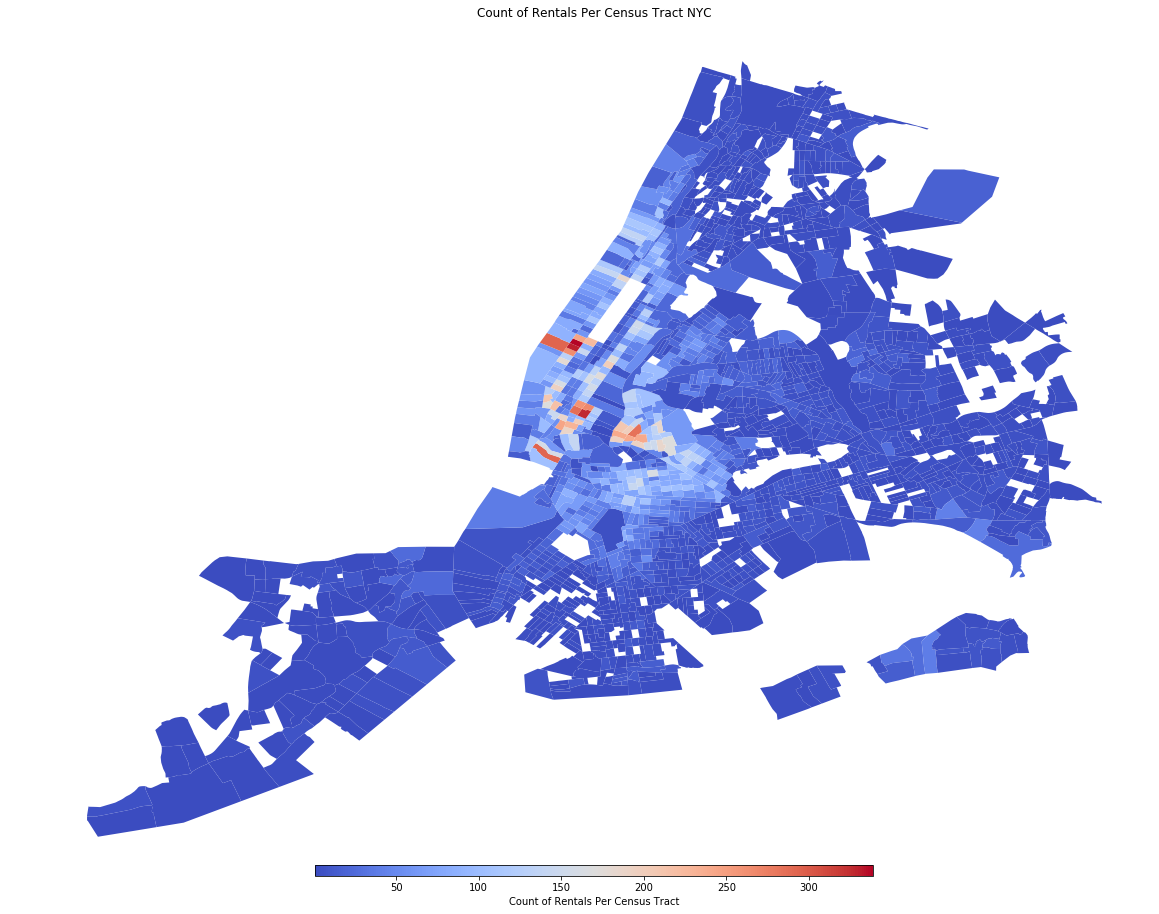

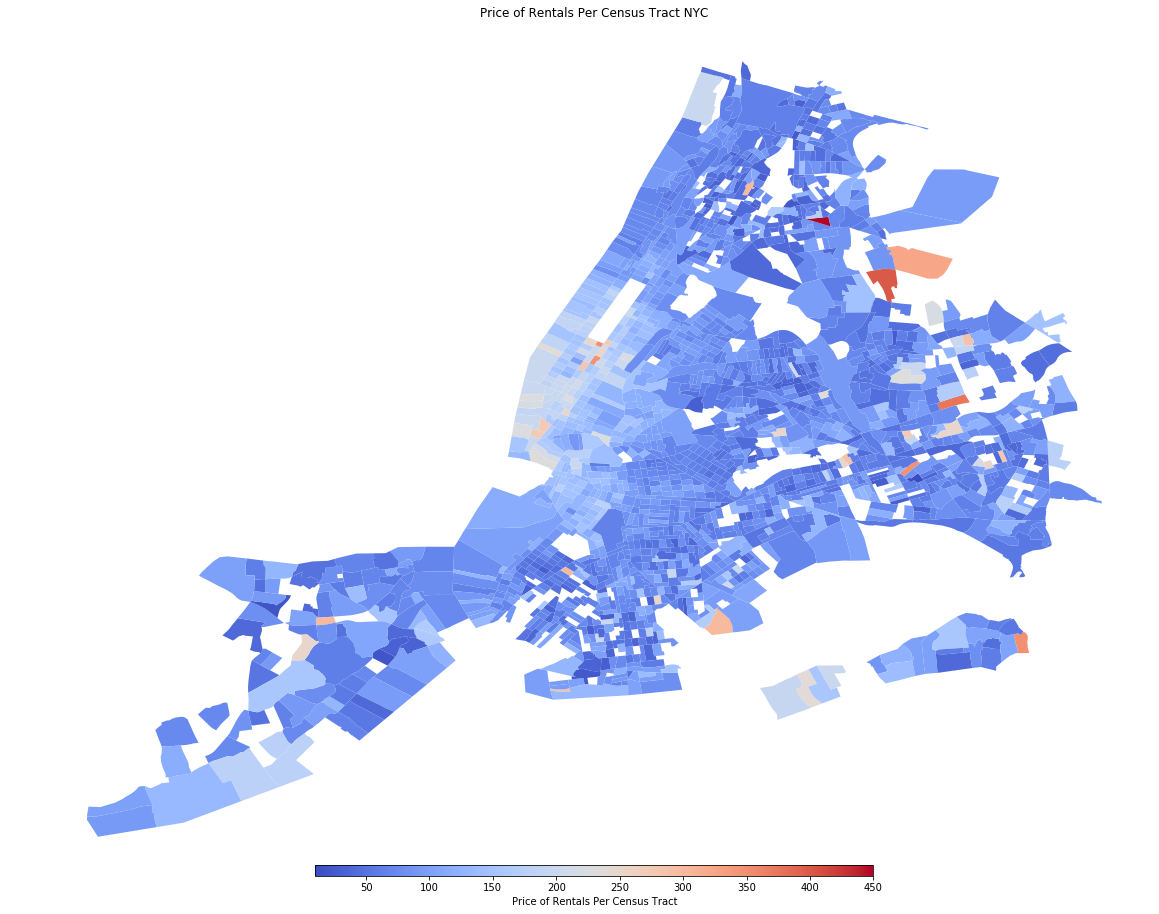

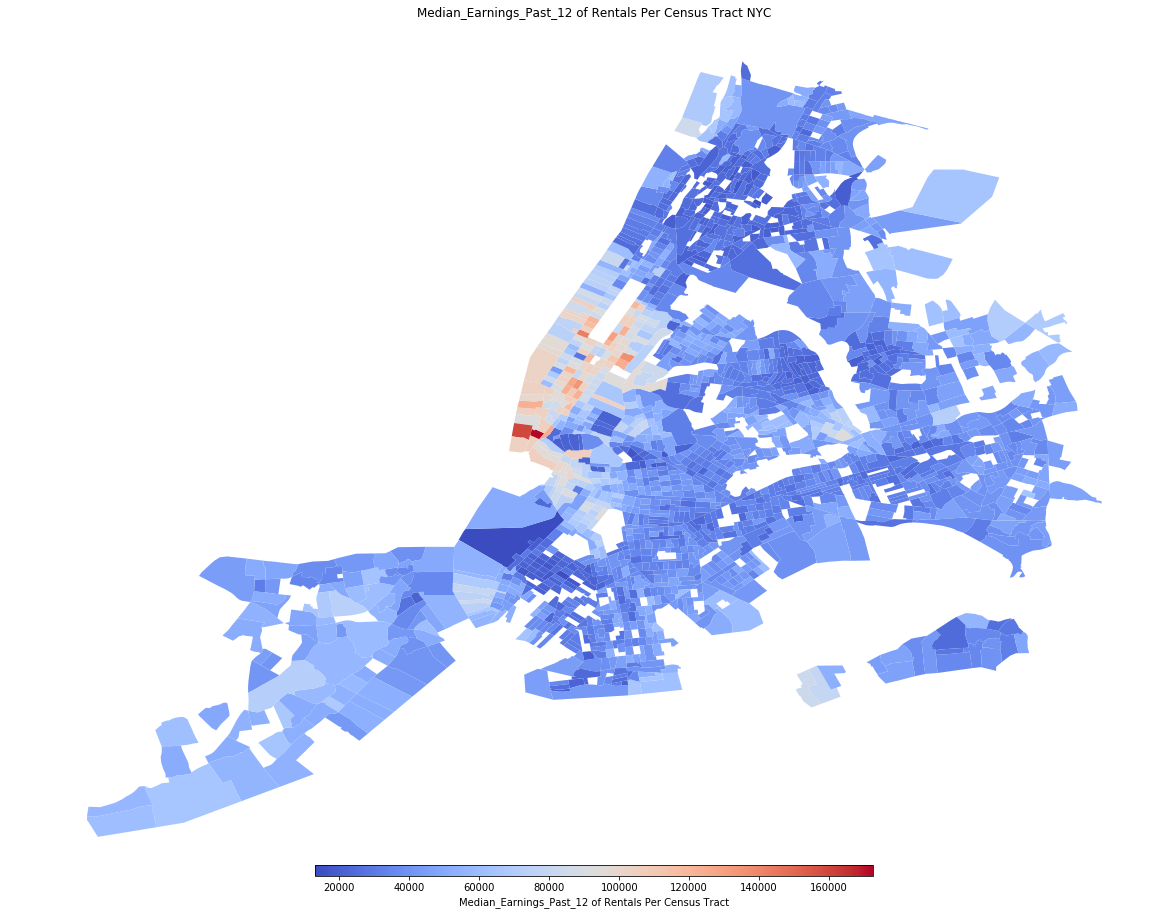

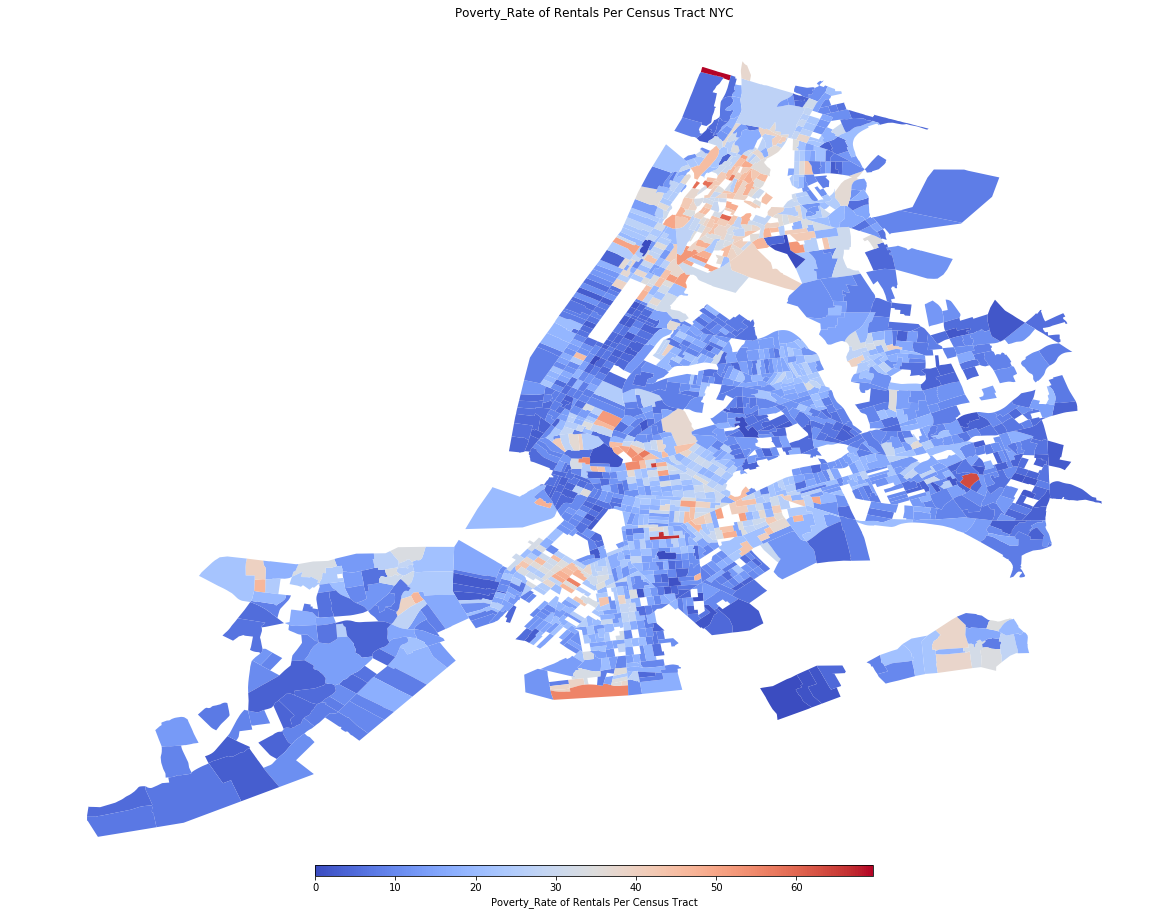

In [63]:
from matplotlib import cm
plot_list = ['count','price','median_earnings_past_12','poverty_rate']



for x in plot_list:
    fig, ax = plt.subplots(1,1,figsize=(20,20))
    mappable = cm.ScalarMappable(cmap='coolwarm')
    mappable.set_array(plot_data[plot_data[x].notna()][x])
    clrbr = plt.colorbar(mappable,orientation='horizontal', shrink=0.5,aspect=50, pad=-0.01)
    clrbr.set_label("{} of Rentals Per Census Tract".format(x.title()))
    plot_data[plot_data[x].notna()].plot(column=x,ax = ax,cmap='coolwarm')
    ax.set_title("{} of Rentals Per Census Tract NYC".format(x.title()))
    plt.axis('off')


<a id='ols'></a>
## Ordinary Least Squares Regression

The first step in the modelling phase of this analysis is to establish a baseline performance with OLS regression.  The main goal of the base model is minimizing the mean squared error while being aware of the assumptions of this regression method.  The assumptions of OLS Regression are homoscedasticity of variance of residuals, error of residuals are linearly indpendent(random), errors are normally distributed and little no mulicollinearity among predictor variables<sup>5</sup>.  The sci-kit learn library will be used to create each model.  The columns neighbourhood_group and neighbourhood are not used for the model.  The census data has census tract level data for each observation so these fields are not necessary.  It would also be easier for the model to generalize to other cities without specific neighborhoods and groups in our predictor variables.  The neighbourhood field also contains many unique values which, when one hot encoded would add a lot of extra variables creating a higher dimenional dataset that would make our models more difficult to interpret.

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

base_model=LinearRegression(normalize=True)

x_feats=['room_type',
       'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'percent_Under_5_years', 'percent_5_to_9_years',
       'percent_10_to_14_years', 'percent_15_to_19_years',
       'percent_20_to_24_years', 'percent_25_to_29_years',
       'percent_30_to_34_years', 'percent_35_to_39_years',
       'percent_40_to_44_years', 'percent_45_to_49_years',
       'percent_50_to_54_years', 'percent_55_to_59_years',
       'percent_60_to_64_years', 'percent_65_to_69_years',
       'percent_70_to_74_years', 'percent_75_to_79_years',
       'percent_80_to_84_years', 'percent_85_years_and_over',
       'median_earnings_past_12', 'unemployment_rate',
       'median_income_household', 'poverty_rate', 'alive_tree_cnt',
       'dead_tree_cnt', 'stump_tree_cnt', 'total_tree_cnt', 'entrance_cnt',
       'days_since_last_review']

y_feat='price'

model_data = final_air_bnb[['price']+x_feats].dropna()
model_data.shape

(48679, 35)

There are a total of 35 variables.  There are 34 predictor variables and 1 target variable(price).  5-fold cross validation will be used to assess performance.  Cross validation is a technique that uses the entire data set for training and for validation.  It is the one of the most widely used methods for estimating prediction error<sup>6</sup>.

In [108]:
def model_scores_reg(y_val,X_val,classifier,folds=5, return_solutions = False,fit_params={}):
	predictions = cross_val_predict(classifier,X_val,y_val,cv=folds,fit_params=fit_params)
	solutions_pred = pd.DataFrame(np.stack([np.array(y_val),predictions],axis=1),columns = ['y_actual','y_pred'])
	return solutions_pred
                                            
def add_dummies(df, dummies_list = ['CONSTRUCTIONTYPE', 'ROOFCOVERTYPE', 'DWELLINGTYPE']):
	for col in dummies_list:
		na = False
		if df[col].isnull().sum() > 0:
			na == True
		df = pd.concat([df, pd.get_dummies(df[col],dummy_na = na,prefix = col,drop_first = True)], axis = 1)
		df.drop(col, axis = 1, inplace = True)
	return df
                                            
def plot_feature_imps(clf, X, check_full_attr = True, only_data = False, split_str='_'):

#     Params: clf = classifer model
#             X = the x values of the model so we can plot their importance
#     Returns:
#             shows a plot of the importances
	try:
		feature_imp = pd.Series(clf.feature_importances_, index = X.columns).sort_values(ascending = False)
	except AttributeError:
		if isinstance(clf.coef_[0],np.ndarray):
			feature_imp = pd.Series(clf.coef_[0], index = X.columns).sort_values(ascending = False)
		else:
			feature_imp = pd.Series(clf.coef_, index = X.columns).sort_values(ascending = False)
        
	if check_full_attr:
		split_str_list1 = [index for index in feature_imp.index.values if index.count(split_str) >0]
		split_str_list2 = []
		for index in split_str_list1:
			col = index[:index.rindex(split_str)]
			split_str_list2.append(col)
			

		for index in split_str_list1:
			x = 0
			try:
				
				col = index[:index.rindex(split_str)]
				if split_str_list2.count(col)>1:
					if col not in feature_imp.index.values:
						feature_imp.loc[col] = feature_imp.loc[index]
					else:
						feature_imp.loc[col] = feature_imp.loc[col]+feature_imp.loc[index]
					feature_imp.drop(index, axis = 0, inplace = True)
			except ValueError:
				continue
				
	feature_imp = feature_imp.sort_values(ascending = False)
	if only_data:
		return feature_imp
		
	fig16, ax16 = (plt.subplots(figsize = (15,40)))
	sns.barplot(x = feature_imp, y = feature_imp.index, ax = ax16)
	return fig16, ax16, feature_imp
                                            
def analyze_regression(data, y_var,X_vars,regressor, return_estimators=True,return_solutions_pred = False,folds=5,verbose=True,fit_params={},check_full_attr=True):
	return_dict = {}
	obj_vars = [col for col in X_vars if data[col].dtype == object]
	if len(obj_vars)>0:
		if verbose:
			print("Adding Dummies")
		data = add_dummies(data, dummies_list = obj_vars)
		if verbose:
			print("Dummies Added")
		new_X_vars = [var for var in data.columns if var in X_vars or '_'.join(var.split('_')[:-1]) in X_vars]
	else:
		new_X_vars = X_vars
	X = data[new_X_vars]
	y = data[y_var]
	if verbose:
		print("Shape of y is {} rows".format(str(y.shape[0])))
		print("Shape of X is {} rows and {} columns".format(str(X.shape[0]), str(X.shape[1])))
	if return_solutions_pred:        
		if verbose:
			print("Getting model scores")
		solutions_pred = model_scores_reg(y,X,regressor,folds=folds,return_solutions=return_solutions_pred,fit_params=fit_params)
		if verbose:
			print("Model scores completed")
		return_dict['solutions_pred'] = solutions_pred
	if verbose:
		print("Training Models with Cross Validation")
	cv_results = cross_validate(regressor,X,y,cv=folds,return_estimator=True, return_train_score=True, scoring=['neg_mean_squared_error'],fit_params=fit_params)
	if verbose:
		print("Cross Validation completed")
	estimators = cv_results.pop('estimator',None)
	if return_estimators:
		return_dict['estimators'] = estimators
	return_dict['summary_df'] = pd.DataFrame(cv_results)
	try:
		if verbose:
			print("Getting Feature Imps.")
		feature_imps_list = [plot_feature_imps(model,X,check_full_attr=check_full_attr,only_data=True) for model in estimators]
		new_df = pd.concat(feature_imps_list,axis = 1,sort=True)    
		feature_imps = new_df.mean(axis=1).sort_values(ascending=False)
		return_dict['feature_imps'] = feature_imps
		if verbose:
			print("Feature_imps acquired")
	except Exception as e:
		print(e)
		print("No Feature Importances available in for this classifier")
	return return_dict

In [66]:

test_dict = analyze_regression(model_data,y_feat,x_feats,base_model)
test_dict.keys()

Adding Dummies
Dummies Added
Shape of y is 48679 rows
Shape of X is 48679 rows and 35 columns
Getting model scores
Model scores completed
Training Models with Cross Validation
Cross Validation completed
Getting Feature Imps.
Feature_imps acquired


dict_keys(['solutions_pred', 'estimators', 'summary_df', 'feature_imps'])

In [67]:
test_dict['summary_df']

,fit_time,score_time,test_neg_mean_squared_error,train_neg_mean_squared_error
0,0.084772,0.005985,-69762.610027,-46895.468498
1,0.070809,0.005985,-40415.530602,-54221.961717
2,0.066820,0.004988,-39564.646913,-54417.655480
3,0.071807,0.003991,-45503.687450,-52935.063020
4,0.055039,0.000000,-63270.689088,-48553.480161


In [68]:
test_dict['summary_df']['test_neg_mean_squared_error'].mean()

-51703.43281584507

There is high variance in our mean squared error.  The model appears to be unstable.  Assumptions will be checked and the model will be tweaked so it performs more consistently accross each fold.

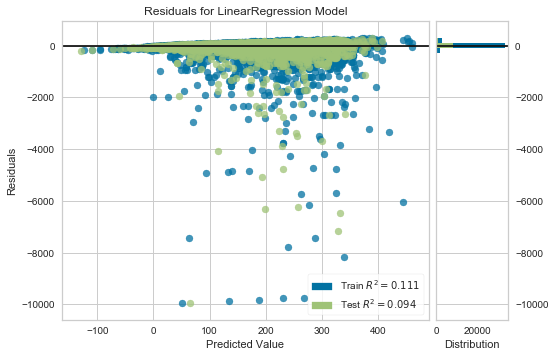

In [69]:
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import ResidualsPlot

model_data = add_dummies(model_data,['room_type'])
X=model_data[model_data.columns[1:]]
y=model_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

visualizer = ResidualsPlot(base_model)
visualizer.fit(X_train,y_train)
visualizer.score(X_test,y_test)
visualizer.show()

There are outliers in our model that could be preventing the model from making accurate predictions.  It is obvious that are assumption of equal variance among the residuals is not holding.  

In [70]:
model_data['price_percentile'] = model_data['price'].rank()/model_data.shape[0]
new_model_data = model_data[model_data['price_percentile']<=.975].reset_index(drop=True)

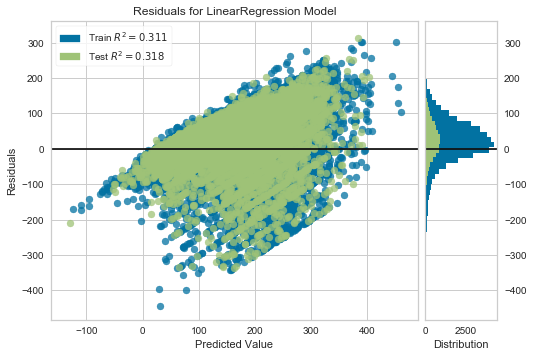

In [71]:
X=new_model_data[new_model_data.columns[1:-1]]
y=new_model_data['price']
def plot_residuals(X,y,model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    visualizer = ResidualsPlot(model)
    visualizer.fit(X_train,y_train)
    visualizer.score(X_test,y_test)
    visualizer.show()

plot_residuals(X,y,base_model)

This residual plot looks more reasonable.  The normality of the residuals assumption looks like it is holding, however variance does not look constant and the errors do not seem random.  The following will be done to attempt to address the violation those two assumptions.

1. Review and address multicollinearity in the predictors using Variance Inflation Factors.
2. Attempt transformations on the target variable.

In [72]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
def address_vif(X_values,vif_threshold=5):
	X_vals = add_constant(X_values)
	vif = [variance_inflation_factor(X_vals.values,i) for i in range(X_vals.shape[1])]
	i=0
	high_vif_dicts = []
	while max(vif[1:]) > vif_threshold:
		append_dict={}
		col_to_remove = X_vals.columns[vif.index(max(vif[1:]))]
		append_dict['orig_feature'] = col_to_remove
		append_dict['vif'] = (max(vif[1:]))
		high_vif_dicts.append(append_dict)
		X_vals = X_vals.drop(columns=col_to_remove)
		vif = [variance_inflation_factor(X_vals.values,i) for i in range(X_vals.shape[1])]
		i+=1
		#Lets make sure we don't get stuck here
		if i%5==0:
			print("{} features removed due to high VIF".format(str(i)))
		if i >30:
			break
	map_dict = dict(zip(X_vals.columns,vif))
	return high_vif_dicts,map_dict,list(X_vals.columns[1:])
    
high_vif_dicts,map_dict,X_vals= address_vif(X)

C:\Users\jfalh\Anaconda3\envs\data_analysis_proj\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\jfalh\Anaconda3\envs\data_analysis_proj\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [73]:
high_vif_dicts

[{'orig_feature': 'alive_tree_cnt', 'vif': inf},
 {'orig_feature': 'percent_25_to_29_years', 'vif': 2250.4807561466005},
 {'orig_feature': 'median_income_household', 'vif': 9.124529476268508}]

In [74]:
X_vals

['minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'percent_Under_5_years',
 'percent_5_to_9_years',
 'percent_10_to_14_years',
 'percent_15_to_19_years',
 'percent_20_to_24_years',
 'percent_30_to_34_years',
 'percent_35_to_39_years',
 'percent_40_to_44_years',
 'percent_45_to_49_years',
 'percent_50_to_54_years',
 'percent_55_to_59_years',
 'percent_60_to_64_years',
 'percent_65_to_69_years',
 'percent_70_to_74_years',
 'percent_75_to_79_years',
 'percent_80_to_84_years',
 'percent_85_years_and_over',
 'median_earnings_past_12',
 'unemployment_rate',
 'poverty_rate',
 'dead_tree_cnt',
 'stump_tree_cnt',
 'total_tree_cnt',
 'entrance_cnt',
 'days_since_last_review',
 'room_type_Private room',
 'room_type_Shared room']

Three features were removed due to high VIF.  VIFs for remaining features are all less than 5 so we have now addressed the multicollinearity assumption.

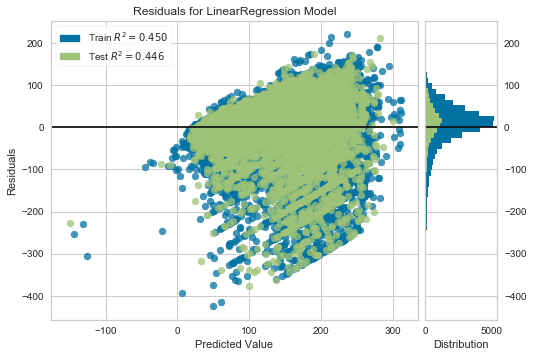

In [75]:
X=new_model_data[X_vals]
y=new_model_data['price']
plot_residuals(X,y,LinearRegression(normalize=True))

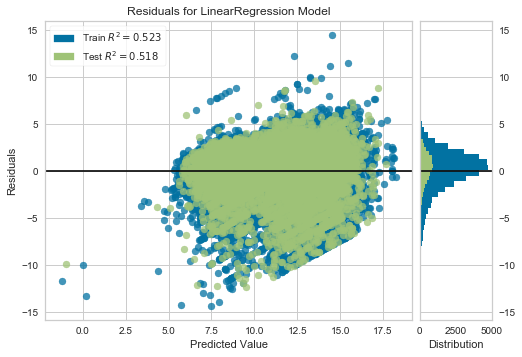

In [76]:
X=new_model_data[X_vals]
y=np.sqrt(new_model_data['price'])
plot_residuals(X,y,LinearRegression(normalize=True))

Our new residual plot still doesn't fit the assumptions perfectly but it is much closer than previously.  The R Squared values are also much higher.  In summary, the following was done to address assumptions and create a more robust OLS model.

1. Outliers were removed by removing observations that had prices greater than the 97.5 percentile.
2. Three highly intercorrelated featrues removed: alive_tree_count, median_income_houshold and percent_25_to_29_years.
3. A square root transformation was done on the target variable to help handle non-linearity.

The dataset is ready to be run again through cross validation to establish our base score to compare with the other models.

In [77]:
new_model_data['price_sqrt'] = np.sqrt(new_model_data['price'])

final_dict = analyze_regression(new_model_data,'price_sqrt',X_vals,LinearRegression(normalize=True))

Shape of y is 47452 rows
Shape of X is 47452 rows and 32 columns
Getting model scores
Model scores completed
Training Models with Cross Validation
Cross Validation completed
Getting Feature Imps.
Feature_imps acquired


In [78]:
final_dict['summary_df']


,fit_time,score_time,test_neg_mean_squared_error,train_neg_mean_squared_error
0,0.058843,0.003990,-5.875416,-5.663811
1,0.044996,0.000000,-5.350642,-5.774404
2,0.064525,0.004988,-5.519298,-5.728923
3,0.057844,0.003990,-5.611858,-5.708487
4,0.051860,0.004987,-6.512208,-5.504131


In [79]:
score_dict = {}

score_dict['OLS']=[final_dict['summary_df']['test_neg_mean_squared_error'].mean(),final_dict['summary_df']['test_neg_mean_squared_error'].std()]
score_dict['OLS']

[-5.77388447283506, 0.4543210648592191]

The variance of the test terms is lower and the model seems much more stable.  Our base mean_squared_error will be 5.77.

<a id='lasso'></a>
## Lasso Regression

The first model we will compare our base OLS model to is Lasso regression.  Lasso regression is a regression technique that applies penalty based on a constant and the beta values for the predictor variables<sup>7</sup>.  Sci-kit learn has the lasso regression model available in the same manner it has linear regression.  Lasso regression employs an alpha parameter that is used for L1 regularization.  An alpha value of zero is the same model as our OLS model above.  As alpha increases, coefficients will trend toward 0 and bias in the model will increase.  Lasso regression is useful in dealing with overfitting.

In [80]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import Lasso

alphas = [0,.0001, .001, 0.01, .1, .5, 2, 5]
alpha_dict = {}
for alpha in alphas:
    alpha_dict['Lasso_{}'.format(str(alpha))] = analyze_regression(new_model_data,'price_sqrt',X_vals,Lasso(alpha=alpha,normalize=True),verbose=False)

In [81]:
scores_df = pd.DataFrame()
feats_df = pd.DataFrame()
for key in alpha_dict.keys():
    scores_df[key] = alpha_dict[key]['summary_df']['test_neg_mean_squared_error']
    feats_df[key] = alpha_dict[key]['feature_imps']
    
scores_df.mean()

Lasso_0        -5.773884 
Lasso_0.0001   -5.782624 
Lasso_0.001    -6.122888 
Lasso_0.01     -11.746040
Lasso_0.1      -11.940439
Lasso_0.5      -11.940439
Lasso_2        -11.940439
Lasso_5        -11.940439
dtype: float64

In [82]:
feats_df

,Lasso_0,Lasso_0.0001,Lasso_0.001,Lasso_0.01,Lasso_0.1,Lasso_0.5,Lasso_2,Lasso_5
poverty_rate,0.034209,0.026694,0.000000,0.000000,0.0,0.0,0.0,0.0
percent_60_to_64_years,0.032605,0.023623,0.000000,0.000000,0.0,0.0,0.0,0.0
dead_tree_cnt,0.023667,0.018702,0.000000,0.000000,0.0,0.0,0.0,0.0
percent_65_to_69_years,0.018474,0.008518,0.000000,0.000000,0.0,0.0,0.0,0.0
percent_80_to_84_years,0.015361,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
percent_70_to_74_years,0.014230,0.003523,0.000000,0.000000,0.0,0.0,0.0,0.0
entrance_cnt,0.011507,0.010023,0.000000,0.000000,0.0,0.0,0.0,0.0
availability_365,0.002895,0.002657,0.000992,0.000000,0.0,0.0,0.0,0.0
percent_40_to_44_years,0.001412,0.000353,0.000000,0.000000,0.0,0.0,0.0,0.0
calculated_host_listings_count,0.000904,0.000931,0.000000,0.000000,0.0,0.0,0.0,0.0


In [83]:
score_dict['Lasso']=[alpha_dict['Lasso_0']['summary_df']['test_neg_mean_squared_error'].mean(),alpha_dict['Lasso_0']['summary_df']['test_neg_mean_squared_error'].std()]
score_dict['Lasso']

[-5.77388447283506, 0.45432106485921964]

With lasso regression, the null hypothesis cannot be rejected.  There is no improvement from Lasso regression.  In fact, the higher the alpha parameter the worse the performance.  From the feats_df, one can see at higher levels of alpha our coefficients trend toward 0.  It also makes sense that there is little improvement as we can see from our original performance in Linear regression that train mean squared error was fairly close test mean squared error which means the model is exibiting a high bias problem instead of a high variance problem (which Lasso helps with).  

<a id='ridge'></a>
## Ridge Regression

Ridge regression is another technique that helps correct for multicollinearity and high variance by adding a bias parameter to improve performance<sup>8</sup>.  This regression method serves a similar purpose as the Lasso regression method as it helps correct for overfitting.  Based on the initial Linear Regression scores it does not appear that our model is overfitting and Ridge regression will not be useful.  While Lasso regression adds a penalty related to a constant times the absolute value of the beta term, ridge adds a penalty related to a constant times the beta term squared.

In [84]:
from sklearn.linear_model import Ridge
ridge_alpha_dict = {}

for alpha in alphas:
    ridge_alpha_dict['Ridge_{}'.format(str(alpha))] = analyze_regression(new_model_data,'price_sqrt',X_vals,Ridge(alpha=alpha,normalize=True),verbose=False)

In [85]:
scores_df = pd.DataFrame()
feats_df = pd.DataFrame()
for key in ridge_alpha_dict.keys():
    scores_df[key] = ridge_alpha_dict[key]['summary_df']['test_neg_mean_squared_error']
    feats_df[key] = ridge_alpha_dict[key]['feature_imps']
    
scores_df.mean()

Ridge_0        -5.773884
Ridge_0.0001   -5.773880
Ridge_0.001    -5.773851
Ridge_0.01     -5.774305
Ridge_0.1      -5.829282
Ridge_0.5      -6.372414
Ridge_2        -7.897004
Ridge_5        -9.217521
dtype: float64

There is a slight improvement between 0 alpha and .001 alpha. 

In [86]:
new_alphas = [0,.001,.002,.003,.004,.005,.006,.007,.008,.009,.01]
ridge_alpha_dict2={}
for alpha in new_alphas:
    ridge_alpha_dict2['Ridge_{}'.format(str(alpha))] = analyze_regression(new_model_data,'price_sqrt',X_vals,Ridge(alpha=alpha,normalize=True),verbose=False)
    
new_scores_df = pd.DataFrame()
for key in ridge_alpha_dict2.keys():
    new_scores_df[key] = ridge_alpha_dict2[key]['summary_df']['test_neg_mean_squared_error']
    


In [87]:
new_scores_df.mean().sort_values(ascending=False)

Ridge_0.002   -5.773835
Ridge_0.003   -5.773836
Ridge_0.001   -5.773851
Ridge_0.004   -5.773854
Ridge_0       -5.773884
Ridge_0.005   -5.773889
Ridge_0.006   -5.773940
Ridge_0.007   -5.774007
Ridge_0.008   -5.774091
Ridge_0.009   -5.774190
Ridge_0.01    -5.774305
dtype: float64

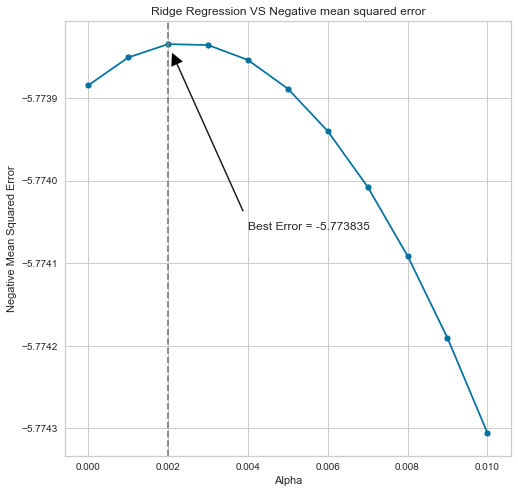

In [88]:
fig,ax=plt.subplots(figsize=(8,8))

sns.lineplot(x=new_alphas,y=new_scores_df.mean(),ax=ax)
sns.scatterplot(x=new_alphas,y=new_scores_df.mean(),ax=ax)
ax.axvline(x=.002,linestyle='--',color='gray')
ax.set_title('Ridge Regression VS Negative mean squared error')
ax.set_ylabel("Negative Mean Squared Error")
ax.set_xlabel("Alpha")
ax.annotate("Best Error = {}".format(str(round(new_scores_df.mean().max(),6))),fontsize=12,xy=(.002,new_scores_df.mean().max()),xytext=(.004,-5.77405),
                                                                                     arrowprops=dict(facecolor='black',shrink=0.05,width=1),horizontalalignment='left',verticalalignment='top');


In [89]:
score_dict['Ridge']=[ridge_alpha_dict2['Ridge_0.002']['summary_df']['test_neg_mean_squared_error'].mean(),ridge_alpha_dict2['Ridge_0.002']['summary_df']['test_neg_mean_squared_error'].std()]
score_dict['Ridge']

[-5.773834614610185, 0.4564704482993954]

In [90]:
str(((score_dict['OLS'][0]-score_dict['Ridge'][0])/score_dict['OLS'][0])*100)+'%'


'0.0008635126856015722%'

With Ridge and an alpha of .002, there is a slight improvement in performance.  The improvement is less than 1/1000th of a percent.  The null hypothesis cannot be rejected for Ridge Regression either.  This makes sense as Ridge helps control for overfitting and based on the previous metrics with Linear regression the model does not appear to have an overfitting problem.

<a id='rf'></a>
## Random Forest Regression

Random forest methods have been used to generate predictions with good performance in relation to prediction error for many benchmark datasets<sup>9</sup>.  Random forests can also learn a lot of complex non linear relationships between data without the need for complex data transformations.  A random forest is an ensemble machine learning method that uses a technique call bagging.  An ensemble machine learning method is one that creates a single model from multiple base models to improve performance.  Bagging or Boostrap Aggregating is a technique that generates an ensemble of models in which each model is trained on a randomly sampled subset of the training data with replacement<sup>10</sup>.  The random forest algorithm is an ensemble of many decision trees using this bagging method.

In [91]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=250,random_state=42,n_jobs=10)

rf_dict = analyze_regression(new_model_data,'price_sqrt',X_vals,rf_model)

Shape of y is 47452 rows
Shape of X is 47452 rows and 32 columns
Getting model scores
Model scores completed
Training Models with Cross Validation
Cross Validation completed
Getting Feature Imps.
Feature_imps acquired


In [92]:
rf_dict['summary_df']['test_neg_mean_squared_error'].mean()

-5.35428596485602

Performance looks promising but it is not quite at the 10% level.  Grid search will be utilized to pick the best parameters.

In [93]:
from sklearn.model_selection import GridSearchCV
model_data_sample = new_model_data.sample(5000)
param_grid = {'max_depth':[5,10,15],'max_features':[4,8,12]}

rf_dict_test = analyze_regression(model_data_sample,'price_sqrt',X_vals,rf_model)
rf_dict_test['summary_df']['test_neg_mean_squared_error'].mean()



Shape of y is 5000 rows
Shape of X is 5000 rows and 32 columns
Getting model scores
Model scores completed
Training Models with Cross Validation
Cross Validation completed
Getting Feature Imps.
Feature_imps acquired


-5.655063318908373

It will take quite a long time to train a random forest model every time with 47000 records so we are taking a subsample to select optimal parameters.  Our baseline is 5.655.

In [94]:
grid = GridSearchCV(rf_model,param_grid=param_grid,cv=5,verbose=3, scoring = 'neg_mean_squared_error')

grid.fit(model_data_sample[X_vals],model_data_sample['price_sqrt'])




Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_depth=5, max_features=4 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=5, max_features=4, score=-6.936629330184598, total=   7.1s
[CV] max_depth=5, max_features=4 .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s


[CV]  max_depth=5, max_features=4, score=-6.767431493047223, total=   0.6s
[CV] max_depth=5, max_features=4 .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s


[CV]  max_depth=5, max_features=4, score=-7.3649586666332025, total=   0.6s
[CV] max_depth=5, max_features=4 .....................................
[CV]  max_depth=5, max_features=4, score=-6.703640920520804, total=   0.5s
[CV] max_depth=5, max_features=4 .....................................
[CV]  max_depth=5, max_features=4, score=-6.433161182727936, total=   0.9s
[CV] max_depth=5, max_features=8 .....................................
[CV]  max_depth=5, max_features=8, score=-6.13384894864532, total=   1.1s
[CV] max_depth=5, max_features=8 .....................................
[CV]  max_depth=5, max_features=8, score=-6.022743576076426, total=   0.8s
[CV] max_depth=5, max_features=8 .....................................
[CV]  max_depth=5, max_features=8, score=-6.533358573207511, total=   0.8s
[CV] max_depth=5, max_features=8 .....................................
[CV]  max_depth=5, max_features=8, score=-5.95171316451754, total=   0.8s
[CV] max_depth=5, max_features=8 .................

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  1.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=10,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [5, 10, 15], 'max_features': [4, 8, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=3)

{'max_depth': 10, 'max_features': 12}


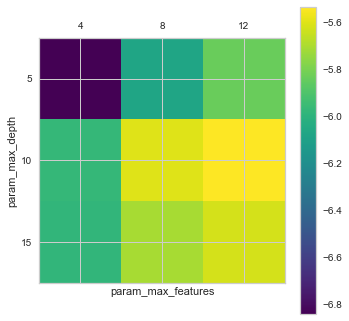

In [100]:
def plot_grid(data, values='mean_test_score',index = 'param_max_depth',columns='param_max_features'):
    results = pd.DataFrame(data)
    res_piv = pd.pivot_table(
        results, values=values, index=index,
        columns=columns)

    plt.matshow(res_piv.values,cmap='viridis')
    plt.xlabel(res_piv.columns.name)
    plt.xticks(range(res_piv.shape[1]), res_piv.columns)
    plt.ylabel(res_piv.index.name)
    plt.yticks(range(res_piv.shape[0]), res_piv.index);
    plt.colorbar()
    
plot_grid(grid.cv_results_)
print(grid.best_params_)

Lets try one more time closer to 10 max depth max features a little higher than 8.

In [101]:
param_grid_new = {'max_depth':[8,10,12],'max_features':[10,15,20]}

grid2 = GridSearchCV(rf_model,param_grid=param_grid_new,cv=5,verbose=3, scoring = 'neg_mean_squared_error')

grid2.fit(model_data_sample[X_vals],model_data_sample['price_sqrt'])



Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_depth=8, max_features=10 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=8, max_features=10, score=-5.608176112021753, total=   8.6s
[CV] max_depth=8, max_features=10 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s


[CV]  max_depth=8, max_features=10, score=-5.553710095174164, total=   1.5s
[CV] max_depth=8, max_features=10 ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.3s remaining:    0.0s


[CV]  max_depth=8, max_features=10, score=-6.033243748535772, total=   1.3s
[CV] max_depth=8, max_features=10 ....................................
[CV]  max_depth=8, max_features=10, score=-5.426735704668365, total=   1.3s
[CV] max_depth=8, max_features=10 ....................................
[CV]  max_depth=8, max_features=10, score=-5.2884133746826985, total=   1.4s
[CV] max_depth=8, max_features=15 ....................................
[CV]  max_depth=8, max_features=15, score=-5.568083650076194, total=   1.8s
[CV] max_depth=8, max_features=15 ....................................
[CV]  max_depth=8, max_features=15, score=-5.507620208725595, total=   1.8s
[CV] max_depth=8, max_features=15 ....................................
[CV]  max_depth=8, max_features=15, score=-5.916249180875466, total=   1.8s
[CV] max_depth=8, max_features=15 ....................................
[CV]  max_depth=8, max_features=15, score=-5.378611360339147, total=   1.9s
[CV] max_depth=8, max_features=15 .......

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=10,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [8, 10, 12], 'max_features': [10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=3)

{'max_depth': 10, 'max_features': 20} -5.491667811235959


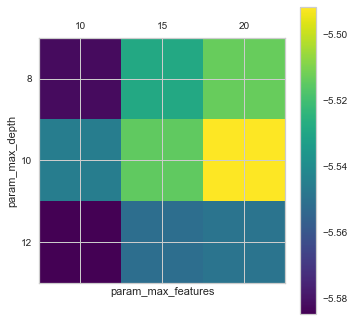

In [104]:
plot_grid(grid2.cv_results_)
print(grid2.best_params_, grid2.best_score_)

With a few grid searches, performance is about 3% better 5.49.  These parameters will be used on the entire dataset.

In [109]:
rf_model_final = RandomForestRegressor(n_estimators=250,max_depth=10,max_features=20,random_state=42,n_jobs=10)

rf_dict_final = analyze_regression(new_model_data,'price_sqrt',X_vals,rf_model_final)

Shape of y is 47452 rows
Shape of X is 47452 rows and 32 columns
Training Models with Cross Validation
Cross Validation completed
Getting Feature Imps.
Feature_imps acquired


In [110]:
rf_dict_final['summary_df']['test_neg_mean_squared_error'].mean()

-5.175246048075765

In [111]:
score_dict['Random Forest']=[rf_dict_final['summary_df']['test_neg_mean_squared_error'].mean(),rf_dict_final['summary_df']['test_neg_mean_squared_error'].std()]
score_dict['Random Forest']

[-5.175246048075765, 0.4167617445006416]

In [112]:
str(((score_dict['OLS'][0]-score_dict['Random Forest'][0])/score_dict['OLS'][0])*100)+'%'

'10.368036069577864%'

With the Random Forest model, there is a 10.4% increase in performance over the OLS model.  In order to achieve this level performance, two grid searches over the max depth and max features parameters were completed to choose optimal parameters.

<a id='xgboost'></a>
## XGBoost Regression

The XGboost variant of gradient boosted trees regression has also performed well on benchmark datasets<sup>11</sup>.  Gradient boosted trees are decision tree based models that are optimized using the gradient descent algorithm.  Due to the base model being decsision tree based it can also learn complex non linear relationships in the data.  XGBoost is also an ensemble method but instead of bagging it employs a technique called boosting.  

In [121]:
from xgboost.sklearn import XGBRegressor

xgb_model = XGBRegressor(n_estimators=250,random_state=42,n_jobs=10,objective='reg:squarederror')

xgb_dict = analyze_regression(new_model_data,'price_sqrt',X_vals,xgb_model)

Shape of y is 47452 rows
Shape of X is 47452 rows and 32 columns
Training Models with Cross Validation
Cross Validation completed
Getting Feature Imps.
Feature_imps acquired


In [122]:
xgb_dict['summary_df']['test_neg_mean_squared_error'].mean()

-5.106941372979741

Using 250 estimators for the XGBRegressor results in an even better mean squared error than our grid searched random forest.  The null hypothesis can be rejected for the XGBoost model.

In [123]:
score_dict['XGBoost']=[xgb_dict['summary_df']['test_neg_mean_squared_error'].mean(),xgb_dict['summary_df']['test_neg_mean_squared_error'].std()]
score_dict['XGBoost']

[-5.106941372979741, 0.4454417098329118]

In [124]:
str(((score_dict['OLS'][0]-score_dict['XGBoost'][0])/score_dict['OLS'][0])*100)+'%'

'11.55102951908977%'

In this analysis, there were several modelling techniques that were employed.  To establish the base Oridinary least squares model, outliers were removed and residual plots were analyzed to determine model fit.  These are common methods of analyzing the fit of a linear model and when those methods were used in the analysis the Rsquared values increased and the model fit the data better.  The disadvantage of these methods is they require manual effort and subjective judgement calls to assess model fit.  For the Lasso and Ridge regression methods, the model was run through several levels of the bias parameter associated with the modelling technique.  At each level of the bias parameter, performance was analyzed until the best bias parameter was chosen.  The disadvantage of this technique is that the levels of the bias parameter are manually chosen.  The grid search technique was employed for the Random Forest model to help choose the best parameters.  Grid search is a technique that will try every combination of parameters that it is given.  It does this by doing cross validation over K folds and averaging out the score.  Heat maps were employed to examine the performance at each parameter until optimal parameters were found.  The distadvantage of the grid search technique is that the search parameters are manually chosen and it can take quite some time to run through every combination.  With XGBoost, the model was simply run with 250 estimators and all the default parameters.  Using these parameters, the performance was already better than the optimized Random Forest model so nothing further was done to improve the model.  

<a id='summary'></a>
## Data Summary and Implications

Overall the null hypothesis that there is not a large difference(less than 10%) in machine learning performance between penalized linear and decision tree based regression methods and ordinary least squares regression can be rejected.  Both the Random Forest and XGBoost models scored had lower mean squared error by more than 10% (10.4% and 11.6% respectively).  One limitation of this result is that no interaction or higher order terms were added to the original dataset.  If higher order terms and/or interactions were added and re-assessed at the linear modelling stage the results from OLS may have performed better. Additional observations are related to the amount of effort it took to tweak each model.  The linear models required the most effort as data had to be removed and manipulated to fit with assumptions and improve performance.  Once that was established for OLS it was quite simple to apply the same data to the Lasso and Ridge models.  The forest based models required little data manipulation and the most that had to be done was tweak some parameters using grid search.  In terms of the time it takes to train each model.  The linear models trained and scored much faster than the forest based models.


In [131]:
final_scores = pd.DataFrame(score_dict).T
final_scores.columns=['Test Mean Squared Error','Test Standard Deviation']
final_scores['Base Model Score'] = final_scores.loc['OLS']['Test Mean Squared Error']
final_scores['Percent Increase in Performance'] = ((final_scores['Base Model Score']-final_scores['Test Mean Squared Error'])/final_scores['Base Model Score'])*100
final_scores



,Test Mean Squared Error,Test Standard Deviation,Base Model Score,Percent Increase in Performance
OLS,-5.773884,0.454321,-5.773884,-0.000000
Lasso,-5.773884,0.454321,-5.773884,-0.000000
Ridge,-5.773835,0.456470,-5.773884,0.000864
Random Forest,-5.175246,0.416762,-5.773884,10.368036
XGBoost,-5.106941,0.445442,-5.773884,11.551030


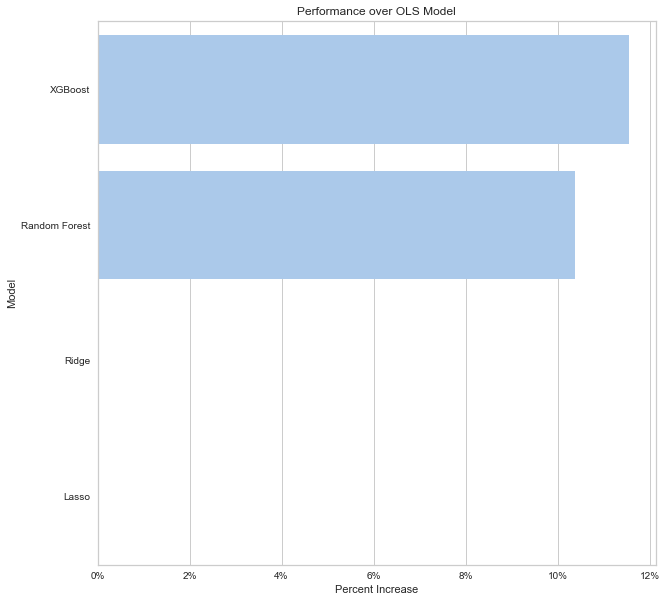

In [139]:
from matplotlib.ticker import FuncFormatter

fig2, ax2 = plt.subplots(figsize=(10,10))
formatter = FuncFormatter(lambda y, pos:"%d%%" % (y))
sns.set_color_codes("pastel")

sns.barplot(x='Percent Increase in Performance',y='index',data=final_scores.iloc[1:].reset_index().sort_values(by='Percent Increase in Performance',ascending=False),
           label='Total',color='b',ax=ax2)


ax2.set_ylabel("Model")
ax2.set_title('Performance over OLS Model')
ax2.xaxis.set_major_formatter(formatter)
ax2.set_xlabel('Percent Increase');


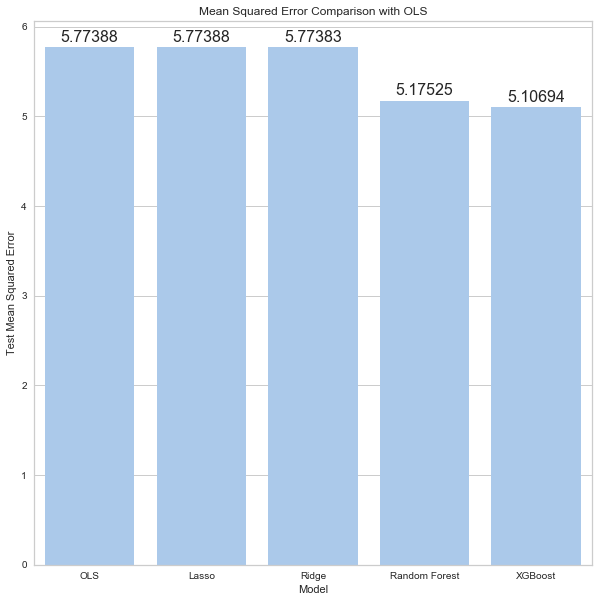

In [174]:
fig2, ax2 = plt.subplots(figsize=(10,10))

sns.set_color_codes("pastel")
final_scores['Test Mean Squared Error'] = final_scores['Test Mean Squared Error'].abs()
plot = sns.barplot(x='index',y='Test Mean Squared Error',data=final_scores.reset_index(),
           label='Total',color='b',ax=ax2)

ax2.set_xlabel("Model")
ax2.set_title('Mean Squared Error Comparison with OLS')
ax2.set_ylabel('Test Mean Squared Error')
for i, height in enumerate(final_scores['Test Mean Squared Error'].tolist()):

    bar_label = '%1.5f' % float(height)
    ax2.text(i, 1.005*height,
             bar_label,
             ha='center', va='bottom', fontsize = 16);



In regards to the dataset in general, one course of action would be to acquire more census data to help better predict price.  Another avenue to explore in relation to the dataset would be to look at revenue earned per time interval instead of price.  One theory is that many of the predictor variables like for example number of reviews might better correlate to revenue earned versus the price of a rental.  Also, the goal of renting a property is to earn revenue and not to price the rental the highest.  There may be rentals in this list that are priced lower but earn substantially more revenue than higher priced rentals.

In relation to the topic studied, the course of action that can be recommended based on the results of the analysis is that if one is not going to add higher order terms or interactions into a linear model that they should utilize ensemble methods like Random forests or XGBoost for prediction.  In review of how the linear models worked it was noted that the Lasso and Ridge regression algorithms already handle for multicollinearity with their bias parameters.  One direction of further study is adding higher order terms and interactions to the dataset and then using Lasso or Ridge regression on all the terms.  The terms that stay in the model (and don't zero out) can be used in our Linear model.  One comparison we can make with this direction is the effectiveness of using Lasso and Ridge regression for parameter selection versus using some the manual techniques used in our analysis like analyzing outliers, residual plots and VIF.  A second approach for further study is a comparison of the performance of Linear regression models (OLS, Lasso/Ridge) and ensemble methods (Random Forest and XGBoost).  The further study could compare the performance of the Linear model using higher order terms and interactions with the ensemble methods without the higher order terms.  The Linear model can use the Lasso and Ridge models as tools for feature selection and dealing with multicollinearity.



<a id='sources'></a>
## Sources

1. Barron, K., Kung, E., & Proserpio, D. (2019). Research: When Airbnb Listings in a City Increase, So Do Rent Prices. Harvard Business Review Digital Articles, 2–4. Retrieved from http://search.ebscohost.com.wgu.idm.oclc.org/login.aspx?direct=true&db=heh&AN=136410699&site=eds-live&scope=site 
 
2. Kan, H. J., Kharrazi, H., Chang, H.-Y., Bodycombe, D., Lemke, K., & Weiner, J. P. (2019). Exploring the use of machine learning for risk adjustment: A comparison of standard and penalized linear regression models in predicting health care costs in older adults. Plos One, 14(3), e0213258. https://doiorg.wgu.idm.oclc.org/10.1371/journal.pone.0213258 
 
3. The Shapely User Manual — Shapely 1.6 documentation. (2019). Shapely.readthedocs.io. Retrieved 25 October 2019, from https://shapely.readthedocs.io/en/stable/manual.html

4. Yu, C. H. (1977). Exploratory data analysis. Methods, 2, 131-160.

5. Tuffery, S. (2011). Data mining and statistics for decision making. Wiley. Retrieved from http://search.ebscohost.com.wgu.idm.oclc.org/login.aspx?direct=true&db=cat07141a&AN=ebc.EBC792450&site=eds-live&scope=site

6. Hastie, T., Tibshirani, R., Friedman, J. (2009). The Elements of Statistical Learning: Data Mining, Inference, and Prediction 2nd edition.  Retrieved from https://web.stanford.edu/~hastie/ElemStatLearn/printings/ESLII_print12.pdf

7. Tibshirani, R. (1996). Regression shrinkage and selection via the lasso. Journal of the Royal Statistical Society: Series B (Methodological), 58(1), 267-288.

8. Hoerl, A. E., & Kennard, R. W. (2000). Ridge Regression: Biased Estimation for Nonorthogonal Problems. Technometrics, 42(1), 80. https://doi-org.wgu.idm.oclc.org/10.1080/00401706.2000.10485983

9. Segal, M. R. (2004). Machine learning benchmarks and random forest regression.

10. Sagi, O., Rokach, L. (2018). Ensemble learning: A survey. WIREs: Data Mining & Knowledge Discovery, 8(4), 1. https://doi-org.wgu.idm.oclc.org/10.1002/widm.1249

11. Chen, T., & Guestrin, C. (2016, August). Xgboost: A scalable tree boosting system. In Proceedings of the 22nd acm sigkdd international conference on knowledge discovery and data mining (pp. 785-794). ACM.